In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Dataset/'Customer Escalations' 
!ls


Mounted at /gdrive
/gdrive/My Drive/Dataset/Customer Escalations
'base(6).csv'			       infersent2.pkl
 base.csv			       init_feat1.csv
 challenge_dictionary_info.csv	       init_feat.csv
 comment_embed.csv		       milesdesc_embed.csv
 crawl-300d-2M.vec		       models.py
 IBI_case_comments_anonymized.csv      notesdesc_embed.csv
 IBI_case_metadata_anonymized.csv      null_impdf.csv
 IBI_case_milestones_anonymized.csv    __pycache__
 IBI_case_status_history_v2.csv        train.bin
 ibi.csv			       txt_feat2.csv
 IBI_test_cases_no_target.csv	       valid.bin
 id_to_lemma_public_translations.csv   zoo


In [ ]:
import pandas as pd
import numpy as np
import random
from collections import Counter

import seaborn as sns

In [ ]:
challenge=pd.read_csv('challenge_dictionary_info.csv')
case_status=pd.read_csv('IBI_case_status_history_v2.csv')
case_comments=pd.read_csv('IBI_case_comments_anonymized.csv')
case_metadata=pd.read_csv('IBI_case_metadata_anonymized.csv')
case_milestones=pd.read_csv('IBI_case_milestones_anonymized.csv')
id2_lemma=pd.read_csv("id_to_lemma_public_translations.csv")
test_cases=pd.read_csv('IBI_test_cases_no_target.csv')
merged_data=pd.read_csv('init_feat1.csv')
merged_data.set_index('REFERENCEID',inplace=True)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# get the embeddings from DOC2VEC_training file
embed_size=100
miles=pd.read_csv('milesdesc_embed.csv').drop(columns='Unnamed: 0')
notes=pd.read_csv('notesdesc_embed.csv').drop(columns='Unnamed: 0')
comments=pd.read_csv('comment_embed.csv').drop(columns='Unnamed: 0')
case_milestones=pd.concat([case_milestones,miles],axis=1)
case_comments=pd.concat([case_comments,comments],axis=1)
case_milestones=pd.concat([case_milestones,notes],axis=1)
miles_col=[str(val)+'_milesdesc' for val in range(0,embed_size)]
notes_col=[str(val)+'_notesdesc' for val in range(0,embed_size)]
comments_col=[str(val)+'_comment' for val in range(0,embed_size)]

### Baseline

##### case_metadata

In [ ]:
min_time_gap=3600
max_time_gap = 14*24*3600
time_interval = 24*3600
escalated=[];columns=[]

ref_ids=case_status.REFERENCEID.unique()
test_ref_ids=test_cases.REFERENCEID.unique()

ref_id_isescalate=case_status[case_status.INV_TIME_TO_NEXT_ESCALATION>0].REFERENCEID.unique()
ref_id_notescalate=case_status[case_status.ISESCALATE=='N'].REFERENCEID.unique()
case_metadata_ref_id=case_metadata.REFERENCEID.unique()
case_metadata.set_index('REFERENCEID',inplace=True)

print(len(ref_id_isescalate),case_status.ISESCALATE.value_counts())

print("number of unique site_code :",case_metadata.SITECODE.nunique())
v=[val for val in case_metadata_ref_id if val in test_ref_ids]
print("number of unique site_code in test_set :",case_metadata.loc[v].SITECODE.nunique())

v=[val for val in case_metadata_ref_id if val not in test_ref_ids]
print("number of unique site_code not in test_set :",case_metadata.loc[v].SITECODE.nunique())
v=[val for val in case_metadata_ref_id if val in ref_id_isescalate]
print("number of unique site_code that are escalated : ",case_metadata.loc[v].SITECODE.nunique())
escalated_site_codes=case_metadata.loc[v].SITECODE.unique()
escalated.append(escalated_site_codes)
columns.append("SITECODE")
print("number of unique contact_company : ",case_metadata.CONTACTCOMPANY.nunique())
print("number of unique company_id : ",case_metadata.COMPANYID.nunique())
print("number of unique company_oid : ",case_metadata.COMPANYOID.nunique())
v=[val for val in case_metadata_ref_id if val in test_ref_ids]
print("number of unique COMPANYID in test_set",case_metadata.loc[v].COMPANYID.nunique())
v=[val for val in case_metadata_ref_id if val not in test_ref_ids]
print("number of unique COMPANYID not in test_set",case_metadata.loc[v].COMPANYID.nunique())
v=[val for val in case_metadata_ref_id if val in ref_id_isescalate]
print("number of unique COMPANYID that are escalated : ",case_metadata.loc[v].COMPANYID.nunique())

print("number of unique INITIALUSERGROUPID : ",case_metadata.INITIALUSERGROUPID.nunique())
print("number of unique INITIALUSERGROUPDESC : ",case_metadata.INITIALUSERGROUPDESC.nunique())
v=[val for val in case_metadata_ref_id if val in test_ref_ids]
print("number of unique INITIALUSERGROUPID in test_set :",case_metadata.loc[v].INITIALUSERGROUPID.nunique())
v=[val for val in case_metadata_ref_id if val not in test_ref_ids]
print("number of unique INITIALUSERGROUPID not in test_set :",case_metadata.loc[v].INITIALUSERGROUPID.nunique())
v=[val for val in case_metadata_ref_id if val in ref_id_isescalate]
print("number of unique INITIALUSERGROUPID that are escalated : ",case_metadata.loc[v].INITIALUSERGROUPID.nunique())
escalated_initialusergroupid=case_metadata.loc[v].INITIALUSERGROUPID.unique()
escalated.append(escalated_initialusergroupid)
columns.append("INITIALUSERGROUPID")

def esc_non_esc(df,cols):
  noescalate_dict=pd.DataFrame((df.groupby([cols]).count())['SITECODE'])
  escalate_dict=(df.loc[ref_id_isescalate].groupby([cols]).count())['SITECODE'].to_dict()

  noescalate_dict.rename({'SITECODE':'num_non_escalation'},axis=1,inplace=True)
  noescalate_dict['num_escalation']=0
  for i in escalate_dict.keys():
    noescalate_dict.loc[i]['num_escalation']=escalate_dict[i]
  noescalate_dict['num_non_escalation']=noescalate_dict['num_non_escalation']-noescalate_dict['num_escalation']
  noescalate_dict['mean_esc'] = (noescalate_dict['num_escalation'] + 1)/(noescalate_dict['num_escalation'] + noescalate_dict['num_non_escalation'] + 100)
  return noescalate_dict
print("num of escalation and non escalation w.r.t INITIALUSERGROUPID")
esc_nonesc_initialusergroupid=esc_non_esc(case_metadata,'INITIALUSERGROUPID')

print("number of unique MEDPROJOPENBY : ",case_metadata.MEDPROJOPENBY.nunique())
print("number of unique IWAYJIRAISSUEID : ",case_metadata.IWAYJIRAISSUEID.nunique())
print("number of unique NEWIWAYJIRAISSUEID : ",case_metadata.NEWIWAYJIRAISSUEID.nunique())
print("MEDPROJOPENBY id - 6763 constitutes percentage : ",45373/case_metadata.shape[0]*100)
tmp_ref_id=case_metadata[case_metadata['MEDPROJOPENBY']=='6763'].index
v=[val for val in ref_id_isescalate if val in tmp_ref_id]
print("number of unique escalated ref_id that corresponds to MEDPROJOPENBY=6763:",len(v))
tmp_ref_id=case_metadata[case_metadata['MEDPROJOPENBY']!='6763'].index
v=[val for val in ref_id_isescalate if val in tmp_ref_id]
print("number of unique escalated ref_id that corresponds to MEDPROJOPENBY!=6763:",len(v))
v=[val for val in case_metadata_ref_id if val in test_ref_ids]
print("number of unique MEDPROJOPENBY in test_set :",case_metadata.loc[v].MEDPROJOPENBY.nunique())
v=[val for val in case_metadata_ref_id if val not in test_ref_ids]
print("number of unique MEDPROJOPENBY not in test_set :",case_metadata.loc[v].MEDPROJOPENBY.nunique())

v=[val for val in case_metadata_ref_id if val in ref_id_isescalate]
print("number of unique MEDPROJOPENBY that are escalated :",case_metadata.loc[v].MEDPROJOPENBY.nunique())
escalated_medprojopenby=case_metadata.loc[v].MEDPROJOPENBY.unique()
columns.append("MEDPROJOPENBY")
escalated.append(escalated_medprojopenby)

print("number of unique MEDPROJECTID : ",case_metadata.MEDPROJECTID.nunique())
print("MEDPROJECTID - 6763 constitutes percentage of all MEDPROJECTID : %0.2f%%"%(45319/case_metadata.shape[0]*100))
tmp_ref_id=case_metadata[case_metadata['MEDPROJECTID']=='6763'].index
v=[val for val in ref_id_isescalate if val in tmp_ref_id]
print("percent unique escalated ref_id that corresponds to MEDPROJECTID=6763: %0.2f% %"%(len(v)/len(tmp_ref_id)*100))
v=[val for val in test_ref_ids if val in tmp_ref_id]
print("percent unique test ref_id that corresponds to MEDPROJECTID=6763: %0.2f% %"%(len(v)/len(tmp_ref_id)*100))

tmp_ref_id=case_metadata[case_metadata['MEDPROJECTID']!='6763'].index
v=[val for val in ref_id_isescalate if val in tmp_ref_id]
print("percent unique escalated ref_id that corresponds to MEDPROJECTID!=6763: %0.2f% %"%(len(v)/len(tmp_ref_id)*100))
v=[val for val in test_ref_ids if val in tmp_ref_id]
print("percent unique test ref_id that corresponds to MEDPROJECTID!=6763: %0.2f% %"%(len(v)/len(tmp_ref_id)*100))


print("number of unique MEDPROJECTAREA : ",case_metadata.MEDPROJECTAREA.nunique())
tmp_ref_id=case_metadata[case_metadata['MEDPROJECTAREA']=='6763'].index
v=[val for val in ref_id_isescalate if val in tmp_ref_id]
print("percent unique escalated ref_id that corresponds to MEDPROJECTAREA=6763: %0.2f% %"%(len(v)/len(tmp_ref_id)*100))
tmp_ref_id=case_metadata[case_metadata['MEDPROJECTAREA']!='6763'].index
v=[val for val in ref_id_isescalate if val in tmp_ref_id]
print("percent unique escalated ref_id that corresponds to MEDPROJECTAREA!=6763: %0.2f% %"%(len(v)/len(tmp_ref_id)*100))
v=[val for val in case_metadata_ref_id if val in test_ref_ids]
print("number of unique MEDPROJECTAREA in test_set :",case_metadata.loc[v].MEDPROJECTAREA.nunique())
v=[val for val in case_metadata_ref_id if val not in test_ref_ids]
print("number of unique MEDPROJECTAREA not in test_set :",case_metadata.loc[v].MEDPROJECTAREA.nunique())
v=[val for val in case_metadata_ref_id if val in ref_id_isescalate]
print("number of unique MEDPROJECTAREA that are escalated :",case_metadata.loc[v].MEDPROJECTAREA.nunique())
escalated_medprojarea=case_metadata.loc[v].MEDPROJECTAREA.unique()
columns.append("MEDPROJECTAREA")
escalated.append(escalated_medprojarea)

for cols in ['PNOTARGET','PRIMARYPRODUCTVERSION','PRIMARYPRODUCTAREAID','PRIMARYPRODUCTOSPLATFORMID']:#,'PROJNUM','CUSTOMER_NAME','CUSTOMER_LABEL']:
  print("number of unique CUSTOMER_LABEL that are escalated :",case_metadata.loc[v][cols].nunique())
  escalated_customerlabel=case_metadata.loc[v][cols].unique()
  columns.append(cols)
  escalated.append(escalated_customerlabel)

print("num of escalation and non escalation w.r.t INITIALUSERGROUPID")

esc_nonesc_premium=esc_non_esc(case_metadata,'PREMIUMCODE')
print("num of escalation and non escalation w.r.t premium_code")
esc_nonesc_ispremium=esc_non_esc(case_metadata,'ISPREMIUM')

print("num of escalation and non escalation w.r.t PRIMARYPRODUCTFAMILYID")
esc_nonesc_primaryproductfamilyid=esc_non_esc(case_metadata,'PRIMARYPRODUCTFAMILYID')

print("num of escalation and non escalation w.r.t CUSTOMER_PHASE")
esc_nonesc_custphase=esc_non_esc(case_metadata,'CUSTOMER_PHASE')

print("number of unique PRIMARYPRODUCTID : ",case_metadata.PRIMARYPRODUCTID.nunique())
print("number of unique PRIMARYPRODUCTDESC : ",case_metadata.PRIMARYPRODUCTDESC.nunique())

v=[val for val in case_metadata_ref_id if val in test_ref_ids]
print("number of unique PRIMARYPRODUCTID in test_set",case_metadata.loc[v].PRIMARYPRODUCTID.nunique())
v=[val for val in case_metadata_ref_id if val not in test_ref_ids]
print("number of unique PRIMARYPRODUCTID not in test_set",case_metadata.loc[v].PRIMARYPRODUCTID.nunique())
v=[val for val in case_metadata_ref_id if val in ref_id_isescalate]
print("number of unique PRIMARYPRODUCTID that are escalated : ",case_metadata.loc[v].PRIMARYPRODUCTID.nunique())
escalated_primaryproductid=case_metadata.loc[v].PRIMARYPRODUCTID.unique()
columns.append("PRIMARYPRODUCTID")
escalated.append(escalated_primaryproductid)

print("number of unique SITECOMPANYID : ",case_metadata.SITECOMPANYID.nunique())
v=[val for val in case_metadata_ref_id if val in test_ref_ids]
print("number of unique SITECOMPANYID in test_set",case_metadata.loc[v].SITECOMPANYID.nunique())
v=[val for val in case_metadata_ref_id if val not in test_ref_ids]
print("number of unique SITECOMPANYID not in test_set",case_metadata.loc[v].SITECOMPANYID.nunique())
v=[val for val in case_metadata_ref_id if val in ref_id_isescalate]
print("number of unique SITECOMPANYID that are escalated : ",case_metadata.loc[v].SITECOMPANYID.nunique())
escalated_sitecompanyid=case_metadata.loc[v].SITECOMPANYID.unique()
escalated.append(escalated_sitecompanyid)
columns.append("SITECOMPANYID")

print("number of unique AGENT_ID : ",case_metadata.AGENT_ID.nunique())
v=[val for val in case_metadata_ref_id if val in test_ref_ids]
print("number of unique AGENT_ID in test_set",case_metadata.loc[v].AGENT_ID.nunique())
v=[val for val in case_metadata_ref_id if val not in test_ref_ids]
print("number of unique AGENT_ID not in test_set",case_metadata.loc[v].AGENT_ID.nunique())
v=[val for val in case_metadata_ref_id if val in ref_id_isescalate]
print("number of unique AGENT_ID that are escalated : ",case_metadata.loc[v].AGENT_ID.nunique())
escalated_primaryproductid=case_metadata.loc[v].AGENT_ID.unique()
escalated.append(escalated_primaryproductid)
columns.append("AGENT_ID")

print("num of escalation and non escalation w.r.t AGENT_ID")
esc_nonesc_agentid=esc_non_esc(case_metadata,'AGENT_ID')
esc_nonesc_agentid.head()


print("number of unique COUNTRY : ",case_metadata.COUNTRY.nunique())
v=[val for val in case_metadata_ref_id if val in test_ref_ids]
print("number of unique COUNTRY in test_set",case_metadata.loc[v].COUNTRY.nunique())
v=[val for val in case_metadata_ref_id if val not in test_ref_ids]
print("number of unique COUNTRY not in test_set",case_metadata.loc[v].COUNTRY.nunique())
v=[val for val in case_metadata_ref_id if val in ref_id_isescalate]
print("number of unique COUNTRY that are escalated : ",case_metadata.loc[v].COUNTRY.nunique())
escalated_country=case_metadata.loc[v].COUNTRY.unique()
escalated.append(escalated_country)
columns.append("COUNTRY")

print("num of escalation and non escalation w.r.t COUNTRY")
esc_nonesc_country=esc_non_esc(case_metadata,'COUNTRY')

print("number of unique BRANCHCODE : ",case_metadata.BRANCHCODE.nunique())
v=[val for val in case_metadata_ref_id if val in test_ref_ids]
print("number of unique BRANCHCODE in test_set",case_metadata.loc[v].BRANCHCODE.nunique())
v=[val for val in case_metadata_ref_id if val not in test_ref_ids]
print("number of unique BRANCHCODE not in test_set",case_metadata.loc[v].BRANCHCODE.nunique())
v=[val for val in case_metadata_ref_id if val in ref_id_isescalate]
print("number of unique BRANCHCODE that are escalated : ",case_metadata.loc[v].BRANCHCODE.nunique())
escalated_branchcode=case_metadata.loc[v].BRANCHCODE.unique()
escalated.append(escalated_branchcode)
columns.append("BRANCHCODE")

print("num of escalation and non escalation w.r.t BRANCHCODE")
esc_nonesc_branchcode=esc_non_esc(case_metadata,'BRANCHCODE')

print("number of unique CUSTOMERNAME : ",case_metadata.CUSTOMERNAME.nunique())
print("number of unique CUSTOMER_NAME : ",case_metadata.CUSTOMER_NAME.nunique())
print("number of unique IBICUSTOMERNAME : ",case_metadata.IBICUSTOMERNAME.nunique())

escalated_ids=dict(zip(columns,escalated))
case_metadata_feat=pd.DataFrame();
case_metadata_feat['REFERENCEID']=ref_ids
case_metadata_feat.set_index('REFERENCEID',inplace=True)
encode_cols=['ISPREMIUM','CUSTOMER_PHASE','CLOUD','PREMIUMCODE','PRIMARYPRODUCTFAMILYID','CONTACTMETHODFLAG','PRIMARYPRODUCTFAMILYDESC']
encode_colsunusual=['MEDPROJOPENBY','MEDPROJECTAREA','MEDPROJECTID']
encode_cols_num=['INITIALUSERGROUPID','PRIMARYPRODUCTDESC','PRIMARYPRODUCTAREADESC','PRIMARYPRODUCTOSPLATFORMDESC','MEDPROJOPENBY'
,'MEDPROJECTAREA','PRIMARYPRODUCTID','SITECOMPANYID','COUNTRY','BRANCHCODE',
'AGENT_ID','PNOTARGET','PRIMARYPRODUCTVERSION','PRIMARYPRODUCTAREAID','PRIMARYPRODUCTOSPLATFORMID']
#encode_cols_num=['INITIALUSERGROUPID','MEDPROJOPENBY','MEDPROJECTAREA','PRIMARYPRODUCTID','SITECOMPANYID','COUNTRY','BRANCHCODE','AGENT_ID']

for cols in columns:
  ids=case_metadata[cols]
  v=[1 if val in escalated_ids[cols] else 0 for val in ids]
  case_metadata_feat[cols+'_esc_intraining']=v
for cols in encode_cols:
   case_metadata_feat[cols]=case_metadata[cols]
for cols in encode_colsunusual:
  ids=case_metadata[cols]
  v=[1 if val!='6763' else 0 for val in ids]
  case_metadata_feat[cols+'_isunusal']=v
for cols in encode_cols_num:
  esc_nonesc=esc_non_esc(case_metadata,cols)
  esc_nonesc=esc_nonesc['mean_esc']
  case_metadata_feat[cols+'_num']=case_metadata[cols].map(esc_nonesc)
  
case_metadata_newfeat=pd.DataFrame()

case_metadata_newfeat['REFERENCEID']=ref_ids
case_metadata_newfeat.set_index('REFERENCEID',inplace=True)
case_metadata_newfeat['PNOTARGET_isunusual']=[1 if val!='uJuK' else 0 for val in case_metadata['PNOTARGET']]
case_metadata_newfeat['ASM_isunusual']=[1 if val!='uJuK' else 0 for val in case_metadata['ASM_NAME']]
case_metadata_newfeat['PROJNUM_isunusual']=[1 if val!='Pz6I' else 0 for val in case_metadata['PROJNUM']]
case_metadata_newfeat['CUSTOMER_LABEL_isunusual']=[1 if val!='uJuK' else 0 for val in case_metadata['CUSTOMER_LABEL']]
case_metadata_newfeat['PRIMARYPRODUCTOSFAMILYDESC_isunusual']=[1 if val!='Qnob' else 0 for val in case_metadata['PRIMARYPRODUCTOSFAMILYDESC']]

install_year_notescalated=[val for val in case_metadata['SITEINSTALLYEAR'].unique() if val not in case_metadata.loc[ref_id_isescalate]['SITEINSTALLYEAR'].unique()]
case_metadata_newfeat['escfree_install_year']=[1 if val in install_year_notescalated else 0 for val in case_metadata['SITEINSTALLYEAR']]
case_metadata_newfeat['PRIMARYPRODUCTOSFAMILYID_isunusual']=[1 if val!=1 else 0 for val in case_metadata['PRIMARYPRODUCTOSFAMILYID']]
case_metadata_newfeat['PRIMARYPRODUCTFAMILYID_isunusual']=[1 if val!=2 else 0 for val in case_metadata['PRIMARYPRODUCTFAMILYID']]
case_metadata_newfeat['common_PRIMARYPRODUCTOSFAMILYID_PRIMARYPRODUCTFAMILYID']=[1 if val>0 else 0 for val in np.sum(case_metadata_newfeat[['PRIMARYPRODUCTOSFAMILYID_isunusual','PRIMARYPRODUCTFAMILYID_isunusual']].values,axis=1)]
case_metadata_newfeat['jiraissue_change']=[0 if val1==case_metadata['NEWIWAYJIRAISSUEID'].values[i] else 1 for i,val1 in enumerate(case_metadata['IWAYJIRAISSUEID'].values)]

#case_metadata_newfeat['IBICUSTOMER_change']=[0 if val1==case_metadata['IBICUSTOMERFIRST'].values[i] else 1 for i,val1 in enumerate(case_metadata['IBICUSTOMERLAST'].values)]
case_metadata_feat=case_metadata_feat.merge(case_metadata_newfeat,left_index=True,right_index=True)
case_metadata_feat.shape

646 N    796410
Y     16704
Name: ISESCALATE, dtype: int64
number of unique site_code : 2649
number of unique site_code in test_set : 1405
number of unique site_code not in test_set : 2351
number of unique site_code that are escalated :  282
number of unique contact_company :  1560
number of unique company_id :  1567
number of unique company_oid :  1567
number of unique COMPANYID in test_set 931
number of unique COMPANYID not in test_set 1414
number of unique COMPANYID that are escalated :  220
number of unique INITIALUSERGROUPID :  17
number of unique INITIALUSERGROUPDESC :  17
number of unique INITIALUSERGROUPID in test_set : 16
number of unique INITIALUSERGROUPID not in test_set : 16
number of unique INITIALUSERGROUPID that are escalated :  13
num of escalation and non escalation w.r.t INITIALUSERGROUPID
number of unique MEDPROJOPENBY :  142
number of unique IWAYJIRAISSUEID :  83
number of unique NEWIWAYJIRAISSUEID :  339
MEDPROJOPENBY id - 6763 constitutes percentage :  84.59587955

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


number of unique escalated ref_id that corresponds to MEDPROJOPENBY!=6763: 237
number of unique MEDPROJOPENBY in test_set : 58
number of unique MEDPROJOPENBY not in test_set : 136
number of unique MEDPROJOPENBY that are escalated : 25
number of unique MEDPROJECTID :  7049
MEDPROJECTID - 6763 constitutes percentage of all MEDPROJECTID : 84.50%
percent unique escalated ref_id that corresponds to MEDPROJECTID=6763: 0.90%
percent unique test ref_id that corresponds to MEDPROJECTID=6763: 24.07%
percent unique escalated ref_id that corresponds to MEDPROJECTID!=6763: 2.87%
percent unique test ref_id that corresponds to MEDPROJECTID!=6763: 21.81%
number of unique MEDPROJECTAREA :  84
percent unique escalated ref_id that corresponds to MEDPROJECTAREA=6763: 0.62%
percent unique escalated ref_id that corresponds to MEDPROJECTAREA!=6763: 1.28%
number of unique MEDPROJECTAREA in test_set : 81
number of unique MEDPROJECTAREA not in test_set : 84
number of unique MEDPROJECTAREA that are escalated : 6

(53635, 48)

##### case_status

In [ ]:
%%time

case_status=pd.read_csv('IBI_case_status_history_v2.csv')
print(case_status.shape)
case_status.set_index('REFERENCEID',inplace=True)

case_start=pd.DataFrame()
case_start['REFERENCEID']=ref_id_isescalate
case_start['case_begin']=0
case_start['case_end']=0
case_start['decision_time']=0
case_start['target']=0
case_start.set_index('REFERENCEID',inplace=True)
temp=case_status[case_status.ISESCALATE=='Y']
counter=0
for i in ref_id_isescalate:
  if len(temp.loc[i].shape)==1:
    case_start.loc[i,'case_end']=temp.loc[i]['SECONDS_SINCE_CASE_START']
    case_start.loc[i,'case_begin']=temp.loc[i]['SECONDS_SINCE_CASE_START']
    case_start.loc[i,'decision_time']=case_status.loc[i][case_status.loc[i]['SECONDS_SINCE_CASE_START']<temp.loc[i]['SECONDS_SINCE_CASE_START']].iloc[-1]['SECONDS_SINCE_CASE_START']
    case_start.loc[i,'target']=case_status.loc[i][case_status.loc[i]['SECONDS_SINCE_CASE_START']<temp.loc[i]['SECONDS_SINCE_CASE_START']].iloc[-1]['INV_TIME_TO_NEXT_ESCALATION']

    #print(case_status.loc[i]['SECONDS_SINCE_CASE_START'])
  else:
    case_start.loc[i,'case_begin']=temp.loc[i].iloc[0]['SECONDS_SINCE_CASE_START']
    case_start.loc[i,'case_end']=temp.loc[i].iloc[-1]['SECONDS_SINCE_CASE_START']
    case_start.loc[i,'decision_time']=case_status.loc[i][case_status.loc[i]['SECONDS_SINCE_CASE_START']<temp.loc[i].iloc[0]['SECONDS_SINCE_CASE_START']].iloc[-1]['SECONDS_SINCE_CASE_START']
    case_start.loc[i,'target']=case_status.loc[i][case_status.loc[i]['SECONDS_SINCE_CASE_START']<temp.loc[i].iloc[0]['SECONDS_SINCE_CASE_START']].iloc[-1]['INV_TIME_TO_NEXT_ESCALATION']

  counter+=1

ref_ids=case_status.index.unique()
ref_id_notescalate=[val for val in ref_ids if val not in ref_id_isescalate]
other_tr=case_status.loc[ref_id_notescalate][['SECONDS_SINCE_CASE_START']]

tmp_training_time_cuts=pd.DataFrame();case_ends=[]
tmp_training_time_cuts['REFERENCEID']=ref_id_notescalate
counter=0
for ids in ref_id_notescalate:
  if len(other_tr.loc[ids].shape)==1:
    case_ends.append(other_tr.loc[ids]['SECONDS_SINCE_CASE_START'])
    counter+=1

  else:
    temp=other_tr.loc[ids]
    temp.sort_values(by='SECONDS_SINCE_CASE_START',inplace=True)
    case_ends.append(temp.loc[ids].iloc[-1]['SECONDS_SINCE_CASE_START'])
tmp_training_time_cuts['case_end']=case_ends

escalation_points_distribution=[]
for i in range(0,101):
  escalation_points_distribution.append(np.quantile(case_start['case_begin']/case_start['case_end'],i/100))
tmp_training_time_cuts['time_cut']=tmp_training_time_cuts['case_end']*random.choices(escalation_points_distribution,k=tmp_training_time_cuts.shape[0])
tmp_training_time_cuts.set_index('REFERENCEID',inplace=True)

other_training_targets=pd.merge(tmp_training_time_cuts,other_tr,left_index=True,right_index=True)
other_training_targets['flag']= np.where((other_training_targets['SECONDS_SINCE_CASE_START'] < other_training_targets['time_cut']), True, False)
other_training_targets=other_training_targets[other_training_targets.flag==True].drop('flag',axis=1)
other_training_targets=other_training_targets.groupby(other_training_targets.index).max()
other_training_targets['decision_time']=other_training_targets['SECONDS_SINCE_CASE_START']
other_training_targets=other_training_targets[['decision_time']].reset_index()
other_training_targets['target']=0

#temp_other_training.rename({'index':'REFERENCEID'},axis=1,inplace=True)
case_start=case_start[['decision_time','target']].reset_index()
training_data=pd.concat([case_start,other_training_targets],ignore_index=True)
training_data.set_index('REFERENCEID',inplace=True)
train_ids=[val for val in training_data.index if val not in test_ref_ids]
train_data=training_data.loc[train_ids]

train_data=train_data.reset_index()
test_cases.rename(columns={'SECONDS_SINCE_CASE_START':'decision_time','INV_TIME_TO_NEXT_ESCALATION':'target'},inplace=True)

merged_data=pd.concat([train_data,test_cases])
train_data.set_index('REFERENCEID',inplace=True)
dec_time=merged_data[['REFERENCEID','decision_time']]
dec_time.set_index('REFERENCEID',inplace=True)

vv=pd.merge(case_status,dec_time,left_index=True,right_index=True)
vv['flag']= np.where((vv['SECONDS_SINCE_CASE_START'] <= vv['decision_time']), True, False)
vv=vv[vv['flag']==True].drop('flag',axis=1)

case_status_feat=pd.DataFrame(index=vv.index.unique())
print(case_status_feat.shape)
z=vv[['SECONDS_SINCE_CASE_START']].diff()
case_status_feat['hist_event_freq']=np.maximum(-1,z.groupby(z.index).mean()/time_interval)
case_status_feat['last_hist_event_gap']=np.maximum(-1,z.groupby(z.index).last()/time_interval)
case_status_feat['severity_first']= vv.groupby(vv.index).first()['SEVERITY']
case_status_feat['severity_last']= vv.groupby(vv.index).last()['SEVERITY']
case_status_feat['severity_change']=np.where((case_status_feat['severity_first']!=case_status_feat['severity_last']),1,0)

from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for cols in ['severity_first','severity_last']:
  case_status_feat[cols]=case_status_feat[cols].astype(str)
  case_status_feat[cols]=le.fit_transform(case_status_feat[cols])


def esc_non_esc(df,cols):
  noescalate_dict=pd.DataFrame((df.groupby([cols]).count())['severity_change'])
  escalate_dict=(df.loc[ref_id_isescalate].groupby([cols]).count())['severity_change'].to_dict()

  noescalate_dict.rename({'severity_change':'num_non_escalation'},axis=1,inplace=True)
  noescalate_dict['num_escalation']=0
  for i in escalate_dict.keys():
    noescalate_dict.loc[i]['num_escalation']=escalate_dict[i]
  noescalate_dict['num_non_escalation']=noescalate_dict['num_non_escalation']-noescalate_dict['num_escalation']
  noescalate_dict['mean_esc'] = (noescalate_dict['num_escalation'] + 1)/(noescalate_dict['num_escalation'] + noescalate_dict['num_non_escalation'] + 100)
  return noescalate_dict
v=esc_non_esc(case_status_feat,'severity_first')
v=v['mean_esc']
case_status_feat['severity_first_num']=case_status_feat['severity_first'].map(v)
v=esc_non_esc(case_status_feat,'severity_last')
v=v['mean_esc']
case_status_feat['severity_last_num']=case_status_feat['severity_last'].map(v)


(813114, 5)
(52968, 0)
CPU times: user 32.8 s, sys: 211 ms, total: 33 s
Wall time: 33.8 s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
merged_data=pd.merge(case_status_feat,case_metadata_feat.loc[dec_time.index],left_index=True,right_index=True)
cols2_onehot=['CUSTOMER_PHASE','CLOUD',	'PREMIUMCODE','PRIMARYPRODUCTFAMILYID','severity_first',	'severity_last','CONTACTMETHODFLAG','PRIMARYPRODUCTFAMILYDESC'	]
for cols in cols2_onehot:
  dummy=pd.get_dummies(merged_data[cols])
  dummy.columns=[cols+str(val) for val in dummy.columns]
  merged_data=pd.concat([merged_data,dummy],axis=1)
merged_data.drop(columns=cols2_onehot,inplace=True)
merged_data.shape

(52968, 77)

##### case_milestones

In [ ]:
challenge=pd.read_csv('challenge_dictionary_info.csv')
challenge.rename({'count':'id_count'},axis=1,inplace=True)
challenge.ner_type=challenge.ner_type.astype(str)
#case_milestones=pd.read_csv('IBI_case_milestones_anonymized.csv')
case_milestones.set_index('REFERENCEID',inplace=True)

case_milestones=case_milestones.merge(dec_time,left_index=True,right_index=True)
case_milestones['flag']=np.where((case_milestones['SECONDS_SINCE_CASE_START']<=case_milestones['decision_time']),True,False)
case_milestones_new=case_milestones[case_milestones.flag==True].drop('flag',axis=1)

case_milestones_txt=case_milestones_new.groupby(case_milestones_new.index).nth(-1)[['MILESTONEDESCRIPTION','NOTEDESCRIPTION']]


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
%%time
tmp=case_milestones_new.NOTEDESCRIPTION.values
tmp_dict=dict(zip(challenge['id'].values,challenge['pos'].values))
pos=[]
gram=['ADP','PROPN','PUNCT','PRON','DET','CCONJ','AUX','SCONJ','SPACE']
for val in tmp:
  tmp1=[k for k in val.split(" ")  if tmp_dict[k] not in gram]
  pos.append(tmp1)
case_milestones_new['NOTEDESCRIPTION']=pos
tmp=case_milestones_new.NOTEDESCRIPTION.values

tmp=case_milestones_new.MILESTONEDESCRIPTION.values
tmp_dict=dict(zip(challenge['id'].values,challenge['pos'].values))
pos=[]
gram=['ADP','PROPN','PUNCT','PRON','DET','CCONJ','AUX','SCONJ','SPACE']
for val in tmp:
  tmp1=[k for k in val.split(" ")  if tmp_dict[k] not in gram]
  pos.append(tmp1)
case_milestones_new['MILESTONEDESCRIPTION']=pos
tmp=case_milestones_new.MILESTONEDESCRIPTION.values

for cols in ['MILESTONEDESCRIPTION','NOTEDESCRIPTION']:
  notes=[]
  for val in case_milestones_new[cols].values:
    notes.append(' '.join(val))
  case_milestones_new[cols]=notes

CPU times: user 12.7 s, sys: 466 ms, total: 13.2 s
Wall time: 13.2 s


In [ ]:

case_milestones_feat=pd.DataFrame(index=case_milestones_new.index.unique())

case_milestones_feat=case_milestones_feat.merge(dec_time,left_index=True,right_index=True)


case_milestones_new['MILESTONEID']=le.fit_transform(case_milestones_new['MILESTONEID'])
g=case_milestones_new.groupby(case_milestones_new.index)

case_milestones_feat['last_milestone_id']=g.nth(-1)['MILESTONEID'].values
case_milestones_feat['last_updated_by']=g.nth(-1)['UPDATED_BY'].values
case_milestones_feat['next2_last_milestone_id']=case_milestones_feat.index.map(g.nth(-2)['MILESTONEID'].to_dict())
case_milestones_feat['nunique_milestoneid']=g.agg({'MILESTONEID':'nunique'}).values
case_milestones_feat['last_milestone_time']=g.nth(-1)['SECONDS_SINCE_CASE_START'].values
case_milestones_feat['last_milestone_desc_length']=[len(val.split(" ")) for val in g.nth(-1)['MILESTONEDESCRIPTION'].values]
tmp_dict=dict(zip((g.nth(-2)['MILESTONEDESCRIPTION']).index,[len(val.split(" ")) for val in g.nth(-2)['MILESTONEDESCRIPTION'].values]))
case_milestones_feat['next2_last_milestone_desc_length']=case_milestones_feat.index.map(tmp_dict)
case_milestones_feat['last_milestone_note_length']=[len(val.split(" ")) for val in g.nth(-1)['NOTEDESCRIPTION'].values]
tmp_dict=dict(zip((g.nth(-2)['MILESTONEDESCRIPTION']).index,[len(val.split(" ")) for val in g.nth(-2)['NOTEDESCRIPTION'].values]))
case_milestones_feat['next2_last_milestone_note_length']=case_milestones_feat.index.map(tmp_dict)
case_milestones_feat['last_milestone_desc_uniqueterms']=[len(np.unique(val.split(" "))) for val in g.nth(-1)['MILESTONEDESCRIPTION'].values]
case_milestones_feat['last_milestone_note_uniqueterms']=[len(np.unique(val.split(" "))) for val in g.nth(-1)['NOTEDESCRIPTION'].values]
print(case_milestones_feat.shape
)
z=case_milestones_new[['SECONDS_SINCE_CASE_START']].diff()
case_milestones_feat['milestone_event_freq']=np.maximum(-1,z.groupby(z.index).mean()/time_interval)
case_milestones_feat['last_milestone_event_gap']=np.maximum(-1,z.groupby(z.index).last()/time_interval)

for cols in ['milestone_id','milestone_desc_length','milestone_note_length']:
  idx=case_milestones_feat[case_milestones_feat['next2_last_'+cols].isna()==True].index
  case_milestones_feat.loc[idx,'next2_last_'+cols]=case_milestones_feat.loc[idx,'last_'+cols]
case_milestones_feat.shape
case_milestones_txt=g.nth(-1)[['MILESTONEDESCRIPTION','NOTEDESCRIPTION']]


feat_cols=['nunique_milestone_desc','nunique_milestone_note','mean_milestone_desc_length','mean_milestone_notes_length','mean_nunique_milestone_desc','mean_nunique_milestone_note']
tmp_feature_dict=dict(zip(feat_cols,[list() for col in feat_cols]))

for groups in g:
  if groups[0] not in case_milestones_feat.index:
    continue
  tmp=[i for val in groups[1]['MILESTONEDESCRIPTION'].values for i in val.split(" ")]
  tmp_feature_dict['nunique_milestone_desc'].append(len(np.unique(tmp)))
  tmp_feature_dict['mean_milestone_desc_length'].append(len((tmp))/len(groups[1]))
  tmp=[len(np.unique(val.split(" "))) for val in groups[1]['MILESTONEDESCRIPTION'].values]
  tmp_feature_dict['mean_nunique_milestone_desc'].append(np.mean(tmp))

  tmp=[i for val in groups[1]['NOTEDESCRIPTION'].values for i in val.split(" ")]
  tmp_feature_dict['nunique_milestone_note'].append(len(np.unique(tmp)))
  tmp_feature_dict['mean_milestone_notes_length'].append(len((tmp))/len(groups[1]))
  tmp=[len(np.unique(val.split(" "))) for val in groups[1]['NOTEDESCRIPTION'].values]

  tmp_feature_dict['mean_nunique_milestone_note'].append(np.mean(tmp))
for cols in feat_cols:
  case_milestones_feat[cols]=tmp_feature_dict[cols]
def esc_non_esc(df,cols):
  noescalate_dict=pd.DataFrame((df.groupby([cols]).count())['nunique_milestoneid'])
  escalate_dict=(df.loc[ref_id_isescalate].groupby([cols]).count())['nunique_milestoneid'].to_dict()

  noescalate_dict.rename({'nunique_milestoneid':'num_non_escalation'},axis=1,inplace=True)
  noescalate_dict['num_escalation']=0
  for i in escalate_dict.keys():
    noescalate_dict.loc[i]['num_escalation']=escalate_dict[i]
  noescalate_dict['num_non_escalation']=noescalate_dict['num_non_escalation']-noescalate_dict['num_escalation']
  noescalate_dict['mean_esc'] = (noescalate_dict['num_escalation'] + 1)/(noescalate_dict['num_escalation'] + noescalate_dict['num_non_escalation'] + 100)  
  return noescalate_dict
v=esc_non_esc(case_milestones_feat,'last_milestone_id')
v=v['mean_esc']
case_milestones_feat['last_milestone_id_num']=case_milestones_feat['last_milestone_id'].map(v)

v=esc_non_esc(case_milestones_feat,'next2_last_milestone_id')
v=v['mean_esc']
case_milestones_feat['next2_last_milestone_id_num']=case_milestones_feat['next2_last_milestone_id'].map(v)

def esc_non_esc_DLINKS(df,cols):
  noescalate_dict=pd.DataFrame((df.groupby([cols]).count())['nunique_milestoneid'])
  escalate_dict=(df.loc[ref_id_isescalate].groupby([cols]).count())['nunique_milestoneid'].to_dict()

  noescalate_dict.rename({'nunique_milestoneid':'num_non_escalation'},axis=1,inplace=True)
  noescalate_dict['num_escalation']=0
  for i in escalate_dict.keys():
    noescalate_dict.loc[i]['num_escalation']=escalate_dict[i]
  noescalate_dict['num_non_escalation']=noescalate_dict['num_non_escalation']-noescalate_dict['num_escalation']
  noescalate_dict['mean_esc'] = (noescalate_dict['num_escalation'] + 1)/(np.sum(noescalate_dict['num_escalation']) + noescalate_dict.shape[0]+ 100)
  return noescalate_dict
v=esc_non_esc_DLINKS(case_milestones_feat,'last_milestone_id')
v=v['mean_esc']
case_milestones_feat['last_milestone_id_dnum']=case_milestones_feat['last_milestone_id'].map(v)

v=esc_non_esc_DLINKS(case_milestones_feat,'next2_last_milestone_id')
v=v['mean_esc']
case_milestones_feat['next2_last_milestone_id_dnum']=case_milestones_feat['next2_last_milestone_id'].map(v)

case_milestones_feat['last_mile_diff']=(case_milestones_feat['last_milestone_time']-case_milestones_feat['decision_time'])/time_interval
case_milestones_feat.drop(columns=['last_milestone_time','decision_time'],inplace=True)
#case_milestones_feat=case_milestones_feat.merge(g.nth(-1)[case_miles_cols],on='REFERENCEID')

case_milestones_feat.shape

(52967, 12)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(52967, 23)

In [ ]:
case_milestones_feat=case_milestones_feat.merge(g.nth(-1)[miles_col],on='REFERENCEID')
case_milestones_feat=case_milestones_feat.merge(g.nth(-1)[notes_col],on='REFERENCEID')
case_milestones_feat.shape

(52967, 223)

##### case_comment

In [ ]:
#case_comments=pd.read_csv('IBI_case_comments_anonymized.csv')
case_comments.set_index('REFERENCEID',inplace=True)
case_comments=case_comments.merge(dec_time,left_index=True,right_index=True)
case_comments['flag']=np.where((case_comments['SECONDS_SINCE_CASE_START']<=case_comments['decision_time']),True,False)

tmp=case_comments.NOTES.values
tmp_dict=dict(zip(challenge['id'].values,challenge['pos'].values))
pos=[]
gram=['ADP','PROPN','PUNCT','PRON','DET','CCONJ','AUX','SCONJ','SPACE']
for val in tmp:
  tmp1=[k for k in val.split(" ")  if tmp_dict[k] not in gram]
  pos.append(tmp1)
case_comments['NOTES']=pos

notes=[]
for val in case_comments.NOTES.values:
  notes.append(' '.join(val))
  
case_comments.NOTES=notes


case_comments_new=case_comments[case_comments.flag==True].drop('flag',axis=1)
case_comments_txt=case_comments_new.groupby(case_comments_new.index).nth(-1)[['NOTES']]

In [ ]:

case_comments_feat=pd.DataFrame(index=case_comments_new.index.unique())
case_comments_feat=case_comments_feat.merge(dec_time,left_index=True,right_index=True)
print(case_comments_feat.index.nunique())

case_comments_new['COMMENT_TYPE']=le.fit_transform(case_comments_new['COMMENT_TYPE'])
g=case_comments_new.groupby(case_comments_new.index)

#case_comments_feat['first_comment_type']=g.nth(0)['COMMENT_TYPE'].values
case_comments_feat['last_comment_type']=g.nth(-1)['COMMENT_TYPE'].values
case_comments_feat['next2_last_comment_type']=case_comments_feat.index.map(g.nth(-2)['COMMENT_TYPE'].to_dict())

case_comments_feat['nunique_comment_type']=g.agg({'COMMENT_TYPE':'nunique'}).values
case_comments_feat['nunique_global_id']=g.agg({'GLOBALID':'nunique'}).values
case_comments_feat['nunique_created_by']=g.agg({'CREATED_BY':'nunique'}).values

case_comments_feat['last_comment_time']=g.nth(-1)['SECONDS_SINCE_CASE_START'].values

case_comments_feat['last_comment_length']=[len(val.split(" ")) for val in g.nth(-1)['NOTES'].values]
tmp_dict=dict(zip((g.nth(-2)['NOTES']).index,[len(val.split(" ")) for val in g.nth(-2)['NOTES'].values]))
case_comments_feat['next2_last_comment_length']=case_comments_feat.index.map(tmp_dict)

case_comments_feat['last_comment_uniqueterms']=[len(np.unique(val.split(" "))) for val in g.nth(-1)['NOTES'].values]

z=case_comments_new[['SECONDS_SINCE_CASE_START']].diff()
case_comments_feat['comment_type_event_freq']=np.maximum(-1,z.groupby(z.index).mean()/time_interval)
case_comments_feat['last_comment_event_gap']=np.maximum(-1,z.groupby(z.index).last()/time_interval)

for cols in ['comment_type','comment_length']:
  idx=case_comments_feat[case_comments_feat['next2_last_'+cols].isna()==True].index
  case_comments_feat.loc[idx,'next2_last_'+cols]=case_comments_feat.loc[idx,'last_'+cols]
case_comments_note=g.nth(-1)['NOTES'].values

feat_cols=['nunique_notes','mean_notes_length','mean_nunique_notes']
tmp_feature_dict=dict(zip(feat_cols,[list() for col in feat_cols]))

for groups in g:
  if groups[0] not in case_comments_feat.index:
    continue
  tmp=[i for val in groups[1]['NOTES'].values for i in val.split(" ")]
  tmp_feature_dict['nunique_notes'].append(len(np.unique(tmp)))
  tmp_feature_dict['mean_notes_length'].append(len((tmp))/len(groups[1]))
  tmp=[len(np.unique(val.split(" "))) for val in groups[1]['NOTES'].values]
  tmp_feature_dict['mean_nunique_notes'].append(np.mean(tmp))

for cols in feat_cols:
  case_comments_feat[cols]=tmp_feature_dict[cols]

def esc_non_esc(df,cols):
  noescalate_dict=pd.DataFrame((df.groupby([cols]).count())['nunique_comment_type'])
  escalate_dict=(df.loc[ref_id_isescalate].groupby([cols]).count())['nunique_comment_type'].to_dict()

  noescalate_dict.rename({'nunique_comment_type':'num_non_escalation'},axis=1,inplace=True)
  noescalate_dict['num_escalation']=0
  for i in escalate_dict.keys():
    noescalate_dict.loc[i]['num_escalation']=escalate_dict[i]
  noescalate_dict['num_non_escalation']=noescalate_dict['num_non_escalation']-noescalate_dict['num_escalation']
  noescalate_dict['mean_esc'] = (noescalate_dict['num_escalation'] + 1)/(noescalate_dict['num_escalation'] + noescalate_dict['num_non_escalation'] + 100)  
  return noescalate_dict

v=esc_non_esc(case_comments_feat,'last_comment_type')
v=v['mean_esc']
case_comments_feat['last_comment_type_num']=case_comments_feat['last_comment_type'].map(v)

v=esc_non_esc(case_comments_feat,'next2_last_comment_type')
v=v['mean_esc']
case_comments_feat['next2_last_comment_type_num']=case_comments_feat['next2_last_comment_type'].map(v)

def esc_non_esc_DLINKS(df,cols):
  noescalate_dict=pd.DataFrame((df.groupby([cols]).count())['nunique_comment_type'])
  escalate_dict=(df.loc[ref_id_isescalate].groupby([cols]).count())['nunique_comment_type'].to_dict()

  noescalate_dict.rename({'nunique_comment_type':'num_non_escalation'},axis=1,inplace=True)
  noescalate_dict['num_escalation']=0
  for i in escalate_dict.keys():
    noescalate_dict.loc[i]['num_escalation']=escalate_dict[i]
  noescalate_dict['num_non_escalation']=noescalate_dict['num_non_escalation']-noescalate_dict['num_escalation']
  noescalate_dict['mean_esc'] = (noescalate_dict['num_escalation'] + 1)/(noescalate_dict['num_escalation'] + noescalate_dict['num_non_escalation'] + 100)  
  return noescalate_dict

v=esc_non_esc_DLINKS(case_comments_feat,'last_comment_type')
v=v['mean_esc']
case_comments_feat['last_comment_type_dnum']=case_comments_feat['last_comment_type'].map(v)

v=esc_non_esc_DLINKS(case_comments_feat,'next2_last_comment_type')
v=v['mean_esc']
case_comments_feat['next2_last_comment_type_dnum']=case_comments_feat['next2_last_comment_type'].map(v)

case_comments_feat['last_comment_time_diff']=(case_comments_feat['last_comment_time']-case_comments_feat['decision_time'])/time_interval

for cols in ['last_comment_type',"next2_last_comment_type"]:
  dummy=pd.get_dummies(case_comments_feat[cols])
  dummy.columns=[cols+str(val) for val in dummy.columns]
  case_comments_feat=pd.concat([case_comments_feat,dummy],axis=1)
case_comments_feat.drop(columns=[ 'last_comment_time','last_comment_type',"next2_last_comment_type"],inplace=True)
#tmp=case_comments_feat.merge(g.nth(-1)[ner_feat],on='REFERENCEID')
case_comments_feat.shape

52968


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(52968, 37)

In [ ]:
case_comments_feat=case_comments_feat.merge(g.nth(-1)[comments_col],on='REFERENCEID')
case_comments_feat.shape

(52968, 137)

### Dataprep

In [ ]:
merged_data=pd.merge(merged_data,case_milestones_feat,left_index=True,right_index=True,how='left')
merged_data=pd.merge(merged_data,case_comments_feat,left_index=True,right_index=True,how='left')
merged_data['decision_time']=merged_data['decision_time']/time_interval

cols2_drop=['last_milestone_id','last_updated_by','next2_last_milestone_id']
merged_data.drop(columns=cols2_drop,inplace=True)
for cols in merged_data.columns:
  merged_data[cols]=merged_data[cols].fillna(merged_data[cols].mean())#,inplace=True)
print(merged_data.shape)


(52968, 434)


In [ ]:
def eval_func(preds, dtrain):
  labels = dtrain.get_label();epsilon=1e-15
  loss = 1 - sum((preds - labels)**2)/(sum((labels - np.mean(labels))**2))
  return "customloss",loss

train_data1=train_data[['target']]
train_data1=train_data1.merge(merged_data,left_index=True,right_index=True)

print(train_data1.shape)

test_cases=pd.read_csv('IBI_test_cases_no_target.csv')

test_cases.set_index('REFERENCEID',inplace=True)
test_cases.drop(columns=['SECONDS_SINCE_CASE_START','INV_TIME_TO_NEXT_ESCALATION'],inplace=True)
test_cases=test_cases.merge(merged_data,left_index=True,right_index=True)
#test_cases['decision_time']=test_cases['decision_time']/time_interval
test_cases

(40244, 435)


,hist_event_freq,last_hist_event_gap,severity_change,severity_first_num,severity_last_num,SITECODE_esc_intraining,INITIALUSERGROUPID_esc_intraining,MEDPROJOPENBY_esc_intraining,MEDPROJECTAREA_esc_intraining,PNOTARGET_esc_intraining,PRIMARYPRODUCTVERSION_esc_intraining,PRIMARYPRODUCTAREAID_esc_intraining,PRIMARYPRODUCTOSPLATFORMID_esc_intraining,PRIMARYPRODUCTID_esc_intraining,SITECOMPANYID_esc_intraining,AGENT_ID_esc_intraining,COUNTRY_esc_intraining,BRANCHCODE_esc_intraining,ISPREMIUM,MEDPROJOPENBY_isunusal,MEDPROJECTAREA_isunusal,MEDPROJECTID_isunusal,INITIALUSERGROUPID_num,PRIMARYPRODUCTDESC_num,PRIMARYPRODUCTAREADESC_num,PRIMARYPRODUCTOSPLATFORMDESC_num,MEDPROJOPENBY_num,MEDPROJECTAREA_num,PRIMARYPRODUCTID_num,SITECOMPANYID_num,COUNTRY_num,BRANCHCODE_num,AGENT_ID_num,PNOTARGET_num,PRIMARYPRODUCTVERSION_num,PRIMARYPRODUCTAREAID_num,PRIMARYPRODUCTOSPLATFORMID_num,PNOTARGET_isunusual,ASM_isunusual,PROJNUM_isunusual,...,60_comment,61_comment,62_comment,63_comment,64_comment,65_comment,66_comment,67_comment,68_comment,69_comment,70_comment,71_comment,72_comment,73_comment,74_comment,75_comment,76_comment,77_comment,78_comment,79_comment,80_comment,81_comment,82_comment,83_comment,84_comment,85_comment,86_comment,87_comment,88_comment,89_comment,90_comment,91_comment,92_comment,93_comment,94_comment,95_comment,96_comment,97_comment,98_comment,99_comment
REFERENCEID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100003,0.207337,0.738449,0,0.000035,0.000035,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,0,0.000586,0.000181,0.000140,0.000112,0.000022,0.000331,0.000181,0.006329,0.000026,0.001661,0.000024,0.00002,0.000215,0.000394,0.000112,0,0,0,...,-0.03055,-0.2103,0.788600,-0.1900,-0.38820,0.38900,-0.05783,-0.18900,0.073550,-0.339000,0.3794,0.56000,-0.03732,-0.11694,-0.40200,0.88670,0.43820,0.2944,0.3726,0.13660,-0.435000,-0.02016,-0.116400,-0.079650,0.03818,0.47900,-0.3838,-0.0493,0.431200,-0.03952,0.18950,0.12350,0.14100,-0.1644,-0.50730,-0.46340,0.43020,0.684600,-0.198100,0.2832
100004,-0.535032,0.052361,0,0.000088,0.000085,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0.000105,0.000234,0.000246,0.000894,0.000022,0.000245,0.000234,0.006061,0.000026,0.000427,0.000024,0.00002,0.000177,0.000246,0.000894,0,1,0,...,0.08105,1.0830,1.031000,0.5310,0.88000,-0.50600,0.05652,-0.10930,-0.194600,-0.113160,-0.5790,1.42600,1.33800,-0.93500,-1.49500,1.14550,0.68550,-1.1030,-0.3064,0.69630,1.178000,-1.51900,-0.558600,1.027000,-0.60250,0.24110,0.4023,0.7030,-0.947000,0.35060,0.68360,0.29700,-0.42600,-0.6147,1.16600,-1.60200,1.05000,0.665500,-0.255900,-0.9100
100005,0.027639,0.078275,0,0.000088,0.000085,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0,0.000161,0.004950,0.005236,0.000112,0.000022,0.000152,0.004950,0.007194,0.000026,0.000366,0.000024,0.00002,0.005319,0.005376,0.000112,0,0,0,...,-0.11190,-0.2673,0.234900,0.2356,1.31000,-0.15320,-0.36280,-0.45340,0.000420,0.743000,-0.7030,0.59130,0.35400,-0.24280,-0.75500,-0.15370,-0.56300,0.4333,-0.2844,-0.05078,0.457500,0.27080,-0.477000,-0.146000,-0.16370,-0.03674,-0.6885,0.9985,-0.504000,0.16110,-0.02802,0.29600,0.12274,-0.8530,0.23850,0.27220,-0.07196,-0.863300,0.744000,-0.4211
100009,0.142743,0.001551,0,0.000035,0.000035,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,0,0.000124,0.000127,0.001672,0.000047,0.000022,0.001672,0.000127,0.000445,0.000026,0.007407,0.000024,0.00002,0.000364,0.001923,0.000047,0,0,0,...,0.13510,0.1700,0.096500,0.1344,0.02187,0.12140,-0.15980,-0.07367,-0.100800,0.003166,0.1129,0.14260,0.09064,-0.13120,-0.02605,0.20650,-0.03503,0.0317,0.2507,-0.05084,-0.062440,-0.01895,-0.083250,-0.103900,0.13620,-0.21900,-0.1827,0.0732,0.289600,0.03668,0.14710,0.05072,-0.03085,-0.1850,0.11786,-0.03876,0.01622,-0.062700,-0.027900,-0.1444
100010,-0.153260,0.009352,0,0.000088,0.000085,0,1,1,1,1,0,1,0,1,1,1,1,1,1,0,1,0,0.000611,0.000607,0.002519,0.003484,0.000022,0.002525,0.000607,0.003311,0.000257,0.000276,0.000024,0.00002,0.006803,0.002770,0.003484,0,1,0,...,-0.78030,-1.4100,-0.013214,0.6250,-0.43630,-0.40500,-0.

### Feature Selection

In [ ]:
"""
 This section is taken from "https://www.kaggle.com/ogrellier/feature-selection-with-null-importances"
  All credits go to ogrellier
"""

from sklearn.metrics import mean_squared_error
import xgboost as xgb
def eval_func1(preds, labels):
  epsilon=1e-15
  loss = 1 - sum((preds - labels)**2)/(sum((labels - np.mean(labels))**2))
  return loss

def get_feature_importances(train_data, shuffle, seed=None):
    y = train_data['target'].copy().values
    if shuffle:
        y = train_data['target'].copy().sample(frac=1.0).values
    seed_val = 10
    params = { #'objective' : 'regression',
        'eta' : 0.001,
        'max_depth' : 5,
        'lambda' : 125,
        'gpu_id':0,
        'tree_method' :'gpu_hist',
        #'eval_metric' : "rmse",
        'min_child_weight' : 1,
        'subsample' : 0.7,
        'colsample_bytree' : 0.75,
        'disable_default_eval_metric' : 1,
        'base_score':0,
        'seed' : seed_val}
    d_train = xgb.DMatrix(train_data.drop(columns=['target']).values,y,feature_names=train_data.drop(columns=['target']).columns)
    model = xgb.train(params, dtrain=d_train, num_boost_round=1000, feval=eval_func, verbose_eval=100)
    preds = model.predict(d_train)
    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(model.get_score(importance_type='gain').keys())
    imp_df["importance_gain"] = list(model.get_score(importance_type='gain').values())
    imp_df["importance_split"] = list(model.get_score(importance_type='weight').values())
    imp_df['trn_score'] = eval_func1(preds,y)
    return imp_df
np.random.seed(123)
actual_imp_df = get_feature_importances(train_data=train_data1, shuffle=False)
actual_imp_df.sort_values(["importance_gain","importance_split"],ascending=False)

,feature,importance_gain,importance_split,trn_score
0,SITECODE_esc_intraining,1.972656,748,0.067473
1,severity_last_num,0.862667,1537,0.067473
12,61_milesdesc,0.856511,474,0.067473
108,nunique_comment_type,0.843669,138,0.067473
350,last_comment_type_dnum,0.815877,8,0.067473
...,...,...,...,...
396,CLOUD2.0,0.001626,1,0.067473
390,last_milestone_desc_length,0.000356,5,0.067473
362,PRIMARYPRODUCTFAMILYID4,0.000080,1,0.067473
377,escfree_install_year,0.000005,3,0.067473


In [ ]:
import time
null_imp_df = pd.DataFrame()
nb_runs = 80
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(train_data=train_data1, shuffle=True)
    #imp_df = get_feature_importances(data=data, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with    1 of   80 (Spent   0.2 min)Done with    2 of   80 (Spent   0.4 min)Done with    3 of   80 (Spent   0.6 min)Done with    4 of   80 (Spent   0.8 min)Done with    5 of   80 (Spent   1.0 min)Done with    6 of   80 (Spent   1.2 min)Done with    7 of   80 (Spent   1.4 min)Done with    8 of   80 (Spent   1.6 min)Done with    9 of   80 (Spent   1.8 min)Done with   10 of   80 (Spent   2.0 min)Done with   11 of   80 (Spent   2.2 min)Done with   12 of   80 (Spent   2.4 min)Done with   13 of   80 (Spent   2.6 min)

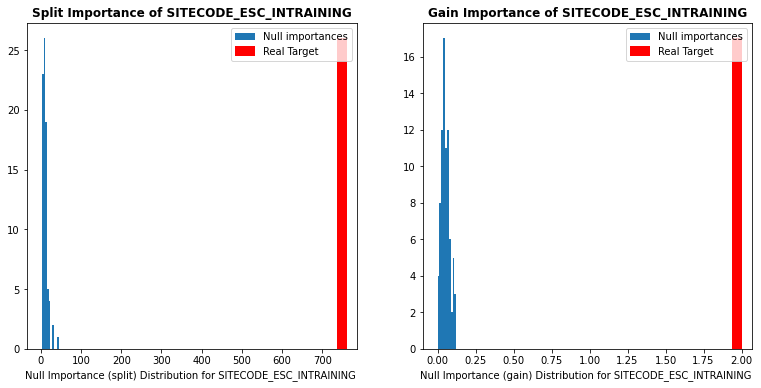

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())
        
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_=actual_imp_df.feature[0])


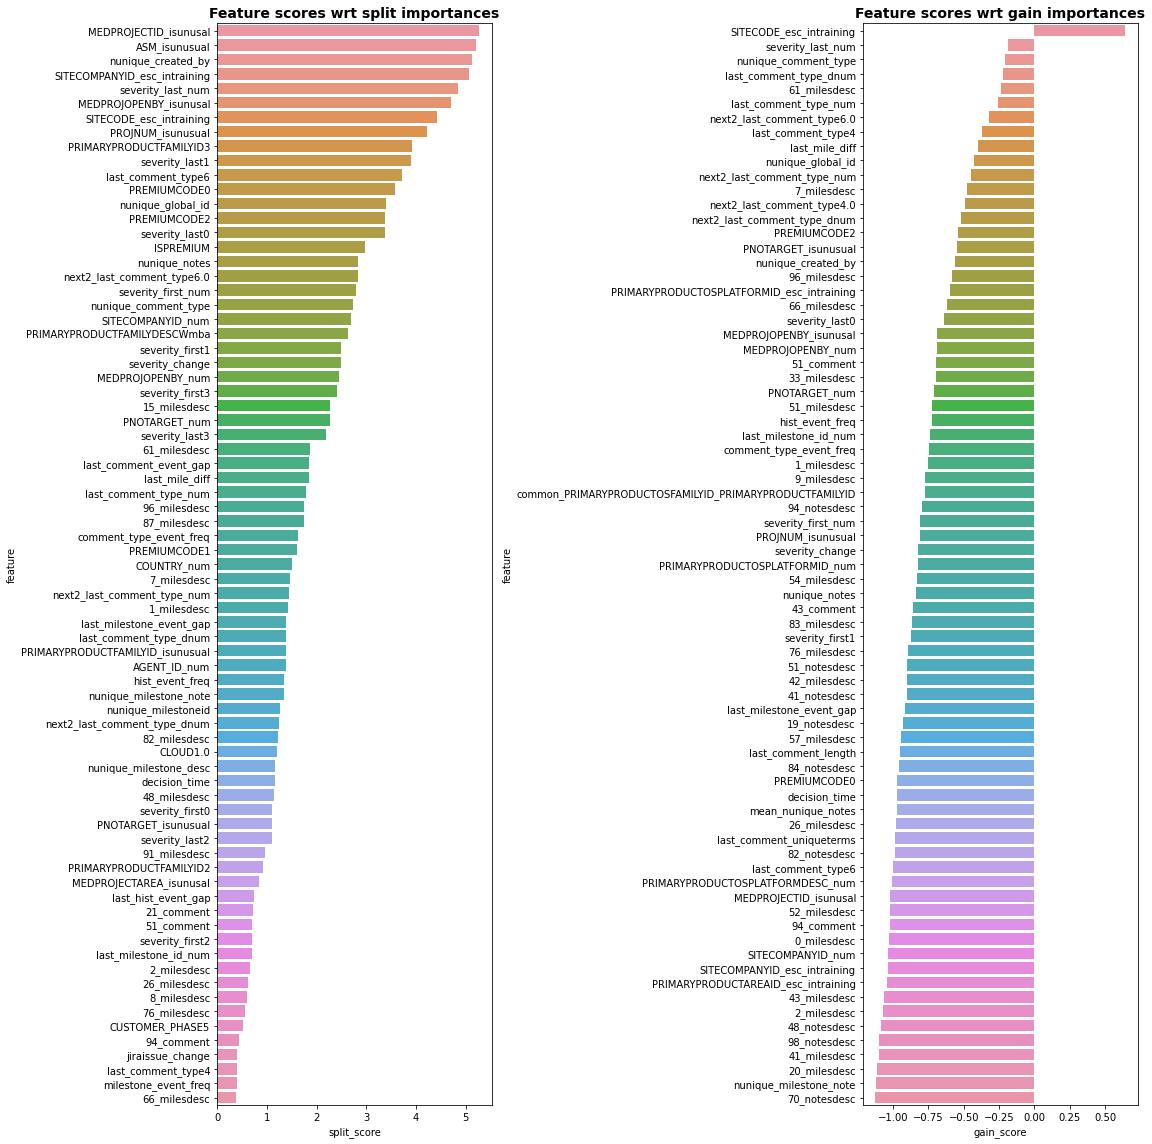

In [ ]:
feature_scores = []
for _f in actual_imp_df['feature']:
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    #print(len(f_null_imps_gain))
    #print(np.percentile(f_null_imps_gain, 75)+np.ones(len(f_null_imps_gain)))
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain,30)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 30)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:75], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:75], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()


In [ ]:
split_score=scores_df.sort_values('split_score', ascending=False)
new_cols=split_score[split_score['split_score']>0].feature.values
len(new_cols)

92

### modeling

In [ ]:
%%time
import xgboost as xgb
from sklearn.model_selection import train_test_split,KFold

folds=5;seed=24
#train_X,val_X,train_y,val_y=train_test_split(train_data1[new_cols],train_data1['target'],test_size=0.2,shuffle=True,random_state=seed)
test_cases=test_cases[new_cols]
kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
prediction=np.zeros(test_cases.shape[0])
seed_val = 10
params = { #'objective' : 'regression',
        'eta' : 0.001,
        'max_depth' : 5,
        'lambda' : 125,
        #'eval_metric' : "rmse",
        'min_child_weight' : 1,
        'subsample' : 0.7,
        'colsample_bytree' : 0.5,
        'disable_default_eval_metric' : 1,
        #'tree_type':'gpu_hist',
        'base_score':0.011,
        'seed' : seed_val}
for train_index, val_index in kf.split(train_data.drop(columns=['target']).values,train_data['target'].values):
  
  train_X = train_data1.drop(columns=['target']).iloc[train_index]
  val_X  = train_data1.drop(columns=['target']).iloc[val_index]

  train_X=train_X[new_cols]
  val_X=val_X[new_cols]
  
  train_y = train_data1['target'].iloc[train_index]
  val_y = train_data1['target'].iloc[val_index]
  
  d_train = xgb.DMatrix(train_X, label=train_y)
  d_valid = xgb.DMatrix(val_X, label=val_y)
  watchlist = [(d_train, 'train'),(d_valid, 'valid')]

  model = xgb.train(params, dtrain=d_train, num_boost_round=2500, evals = watchlist,feval=eval_func,  verbose_eval=100)
  preds = model.predict(xgb.DMatrix(val_X))
  prediction+=model.predict(xgb.DMatrix(test_cases))
  if is_onefold==True:
    prediction+=model.predict(xgb.DMatrix(test_cases))
    break
  prediction+=model.predict(xgb.DMatrix(test_cases))/folds
  


[0]	train-customloss:2.2e-05	valid-customloss:4e-05
[100]	train-customloss:0.008726	valid-customloss:0.007626
[200]	train-customloss:0.016637	valid-customloss:0.014389
[300]	train-customloss:0.024024	valid-customloss:0.020433
[400]	train-customloss:0.030774	valid-customloss:0.025891
[500]	train-customloss:0.037249	valid-customloss:0.031336
[600]	train-customloss:0.043145	valid-customloss:0.036094
[700]	train-customloss:0.04862	valid-customloss:0.040506
[800]	train-customloss:0.053893	valid-customloss:0.044674
[900]	train-customloss:0.058923	valid-customloss:0.048514
[1000]	train-customloss:0.063801	valid-customloss:0.052322
[1100]	train-customloss:0.068373	valid-customloss:0.05572
[1200]	train-customloss:0.07269	valid-customloss:0.058891
[1300]	train-customloss:0.076694	valid-customloss:0.06175
[1400]	train-customloss:0.080598	valid-customloss:0.064494
[1500]	train-customloss:0.084326	valid-customloss:0.067242
[1600]	train-customloss:0.087806	valid-customloss:0.06956
[1700]	train-custo

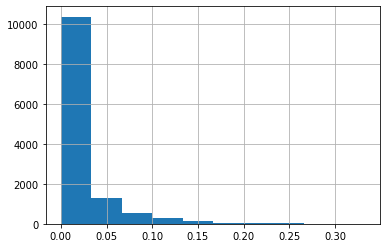

In [ ]:
prediction[prediction<0]=0

prediction[prediction>1]=1
prediction=prediction*1.05
sub=pd.read_csv('IBI_test_cases_no_target.csv')
sub.drop(columns=['SECONDS_SINCE_CASE_START','REFERENCEID'],inplace=True)

sub['INV_TIME_TO_NEXT_ESCALATION']=prediction
sub['INV_TIME_TO_NEXT_ESCALATION'].hist()

In [ ]:
from google.colab import files
sub.to_csv("ibi.csv",index=None,header=None)
files.download("ibi.csv")